In [1]:
from google.colab import files

# Upload a zip file containing data folders
uploaded = files.upload()

Saving train.csv.zip to train.csv.zip


In [2]:
# Unzip data
!unzip train.csv.zip train.csv

Archive:  train.csv.zip
  inflating: train.csv               


In [3]:
import csv
import numpy

# Initialize lists to store training images and labels
images_list = []
labels_list = []

# Initialize a dictionary to count the occurrences of each category
category_count = {}

# Open the 'train.csv' file
with open('train.csv') as train_file:

    # Create a CSV reader
    csv_reader = csv.reader(train_file)

    # Skip the header row
    next(csv_reader)

    # Iterate through each row in the CSV file
    for row in csv_reader:

        # Extract pixel values from the row and convert them to a NumPy array
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_array = numpy.array(pixels_list, dtype='uint8')

        # Reshape the 1D array to a 2D image (48x48 pixels)
        image = pixels_array.reshape((48, 48))

        # Append the image to the list
        images_list.append(image)

        # Extract label information
        label_str = row[0]

        # Calculate the count of occurrences for each category
        count = 0
        if label_str in category_count:
            count = category_count[label_str] + 1
        category_count[label_str] = count

        # Convert the label string to an integer and append it to the labels list
        label = int(label_str)
        labels_list.append(label)

# Convert the lists to NumPy arrays
x_train = numpy.array(images_list)
y_train = numpy.array(labels_list)

# Display the shapes of the training data arrays
print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))


x_train shape: (28709, 48, 48)
y_train shape: (28709,)


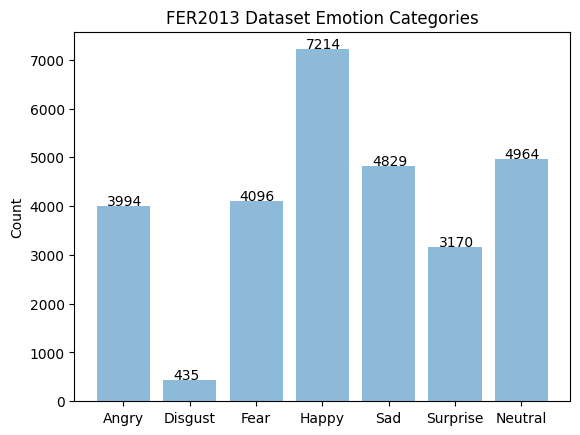

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define categories and their positions for the bar chart
emotion_categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_positions = numpy.arange(len(emotion_categories))

# Initialize a list to store category counts
category_counts = []

# Iterate through each label to get the counts
for label in range(len(emotion_categories)):
    label_str = str(label)
    count = category_count[label_str]
    category_counts.append(count)

    # Display the count above each bar
    plt.text(label - 0.25, count + 15, str(count))

# Draw the histogram
plt.bar(y_positions, category_counts, align='center', alpha=0.5)
plt.xticks(y_positions, emotion_categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Emotion Categories')

plt.show()


Sample Label: 0


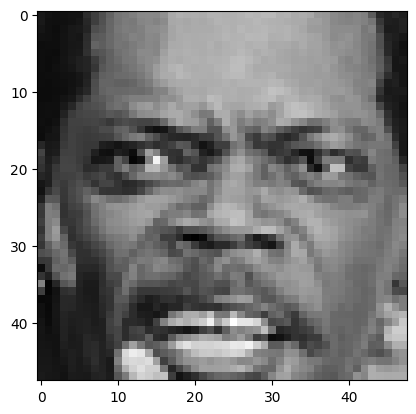

In [7]:
sample_image = x_train[10]
sample_label = y_train[10]

print('Sample Label: ' + str(sample_label))
plt.imshow(sample_image, cmap='gray')


In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train, test_size=0.2)

# Normalize pixel values to the range [0, 1]
x_train_split, x_test_split = x_train_split / 255.0, x_test_split / 255.0

# Reshape the data for compatibility with the convolutional neural network (CNN)
x_train_split = x_train_split.reshape(len(x_train_split), 48, 48, 1)
x_test_split = x_test_split.reshape(len(x_test_split), 48, 48, 1)

# Display the shapes of the training and testing sets
print(x_train_split.shape)
print(x_test_split.shape)


(22967, 48, 48, 1)
(5742, 48, 48, 1)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a Sequential model
custom_model = Sequential()

# 1st convolution layer
custom_model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
custom_model.add(Dropout(0.3))

# 2nd convolution layer
custom_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
custom_model.add(Dropout(0.3))

# 3rd convolution layer
custom_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
custom_model.add(Dropout(0.3))

# 4th convolution layer
custom_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
custom_model.add(Dropout(0.3))

# Fully connected layer
custom_model.add(Flatten())
custom_model.add(Dense(512, activation='relu'))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(256, activation='relu'))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(64, activation='relu'))
custom_model.add(Dropout(0.3))

# Output layer with 7 neurons for 7 categories
custom_model.add(Dense(7, activation='softmax'))

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
custom_optimizer = Adam(learning_rate=0.001)
custom_model.compile(optimizer=custom_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Display model summary
custom_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                        

In [10]:
# Callbacks
custom_early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
custom_reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = custom_model.fit(x_train_split,
                                    y_train_split,
                                    batch_size=64,
                                    epochs=100,
                                    validation_data=(x_test_split, y_test_split),
                                    callbacks=[custom_early_stopping, custom_reduce_learning_rate])


Epoch 1/100
359/359 [==============================] - 39s 57ms/step - loss: 1.8820 - accuracy: 0.2323 - val_loss: 1.8179 - val_accuracy: 0.2452 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 19s 52ms/step - loss: 1.6867 - accuracy: 0.3203 - val_loss: 2.1020 - val_accuracy: 0.2720 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 19s 52ms/step - loss: 1.5175 - accuracy: 0.3986 - val_loss: 1.6830 - val_accuracy: 0.3288 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 19s 52ms/step - loss: 1.3971 - accuracy: 0.4626 - val_loss: 1.3672 - val_accuracy: 0.4697 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 18s 51ms/step - loss: 1.3222 - accuracy: 0.4990 - val_loss: 1.3489 - val_accuracy: 0.4732 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 19s 53ms/step - loss: 1.2592 - accuracy: 0.5224 - val_loss: 1.2445 - val_accuracy: 0.5190 - lr: 0.0010
Epoch 7/100
359/359 [==============================]

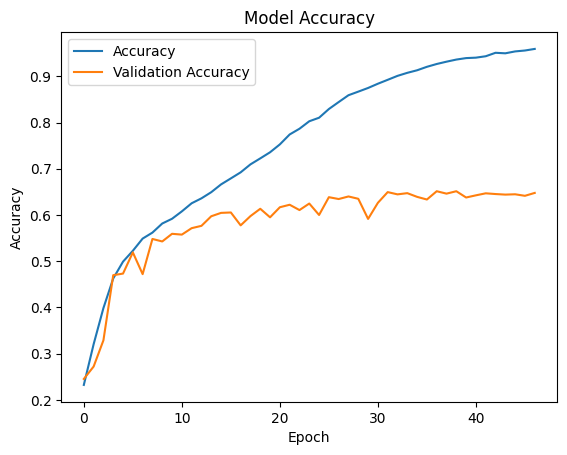

In [11]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

In [12]:
# Evaluate the model before improvement
_, accuracy_before_improvement = custom_model.evaluate(x_test_split, y_test_split)
print('Accuracy before improvement: {}'.format(accuracy_before_improvement))


180/180 [==============================] - 2s 9ms/step - loss: 2.0598 - accuracy: 0.6477
Accuracy before improvement: 0.6476837396621704


In [13]:
# Generate hard data
misclassified_images = []
misclassified_labels = []

# Make predictions using the custom model
predictions_custom = custom_model.predict(x_test_split)

# Iterate through predictions and true labels
for i, predicted_values in enumerate(predictions_custom):
    predicted_label = numpy.argmax(predicted_values)
    true_label = y_test_split[i]

    # Check if the prediction is incorrect
    if predicted_label != true_label:
        # If predicted incorrectly, append to arrays
        misclassified_image = x_test_split[i]
        misclassified_images.append(misclassified_image)
        misclassified_labels.append(true_label)

# Convert the lists to NumPy arrays
x_misclassified = numpy.array(misclassified_images)
y_misclassified = numpy.array(misclassified_labels)

# Display the shapes of the misclassified data
print(x_misclassified.shape)
print(y_misclassified.shape)


180/180 [==============================] - 2s 8ms/step
(2023, 48, 48, 1)
(2023,)


In [15]:
# Train the model on hard data
x_misclassified_train, x_misclassified_test, y_misclassified_train, y_misclassified_test = train_test_split(x_misclassified, y_misclassified, test_size=0.2)
history_hard_data = custom_model.fit(x_misclassified_train,
                                     y_misclassified_train,
                                     batch_size=64,
                                     epochs=50,
                                     validation_data=(x_misclassified_test, y_misclassified_test),
                                     callbacks=[custom_early_stopping, custom_reduce_learning_rate])


Epoch 1/50
26/26 [==============================] - 2s 64ms/step - loss: 1.5493 - accuracy: 0.3337 - val_loss: 1.5982 - val_accuracy: 0.2691 - lr: 5.3144e-04
Epoch 2/50
26/26 [==============================] - 1s 57ms/step - loss: 1.4825 - accuracy: 0.3572 - val_loss: 1.5312 - val_accuracy: 0.3012 - lr: 5.3144e-04
Epoch 3/50
26/26 [==============================] - 1s 50ms/step - loss: 1.4027 - accuracy: 0.3906 - val_loss: 1.4622 - val_accuracy: 0.3407 - lr: 5.3144e-04
Epoch 4/50
26/26 [==============================] - 1s 51ms/step - loss: 1.3386 - accuracy: 0.3900 - val_loss: 1.4129 - val_accuracy: 0.3975 - lr: 5.3144e-04
Epoch 5/50
26/26 [==============================] - 1s 58ms/step - loss: 1.2947 - accuracy: 0.4351 - val_loss: 1.3623 - val_accuracy: 0.4148 - lr: 5.3144e-04
Epoch 6/50
26/26 [==============================] - 1s 55ms/step - loss: 1.2539 - accuracy: 0.4487 - val_loss: 1.2942 - val_accuracy: 0.4469 - lr: 5.3144e-04
Epoch 7/50
26/26 [==============================] - 

In [17]:
# Perform data augmentation
custom_data_generator = ImageDataGenerator(featurewise_center=False,
                                           featurewise_std_normalization=False,
                                           rotation_range=10,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           zoom_range=.1,
                                           horizontal_flip=True)

# Create a data generator flow
data_flow = custom_data_generator.flow(x_train_split,
                                       y_train_split,
                                       batch_size=64)

# Train the model again with augmented data to balance out
history_data_augmentation = custom_model.fit(data_flow,
                                             epochs=50,
                                             validation_data=(x_test_split, y_test_split),
                                             callbacks=[custom_early_stopping, custom_reduce_learning_rate])


Epoch 1/50
359/359 [==============================] - 22s 60ms/step - loss: 1.0649 - accuracy: 0.6233 - val_loss: 0.6726 - val_accuracy: 0.7736 - lr: 3.8742e-04
Epoch 2/50
359/359 [==============================] - 23s 64ms/step - loss: 1.0229 - accuracy: 0.6409 - val_loss: 0.7170 - val_accuracy: 0.7520 - lr: 3.8742e-04
Epoch 3/50
359/359 [==============================] - 23s 63ms/step - loss: 0.9918 - accuracy: 0.6476 - val_loss: 0.6884 - val_accuracy: 0.7647 - lr: 3.8742e-04
Epoch 4/50
359/359 [==============================] - 22s 61ms/step - loss: 0.9550 - accuracy: 0.6619 - val_loss: 0.6999 - val_accuracy: 0.7443 - lr: 3.8742e-04
Epoch 5/50
359/359 [==============================] - 22s 62ms/step - loss: 0.9398 - accuracy: 0.6698 - val_loss: 0.7036 - val_accuracy: 0.7421 - lr: 3.8742e-04
Epoch 6/50
359/359 [==============================] - 22s 60ms/step - loss: 0.9253 - accuracy: 0.6717 - val_loss: 0.7286 - val_accuracy: 0.7262 - lr: 3.8742e-04
Epoch 7/50
359/359 [==============

In [18]:
# Evaluate the model after improvement
_, accuracy_after_improvement = custom_model.evaluate(x_test_split, y_test_split)
print('Accuracy after improvement: {}'.format(accuracy_after_improvement))


180/180 [==============================] - 2s 8ms/step - loss: 0.7335 - accuracy: 0.7323
Accuracy after improvement: 0.7323232293128967


180/180 [==============================] - 1s 7ms/step


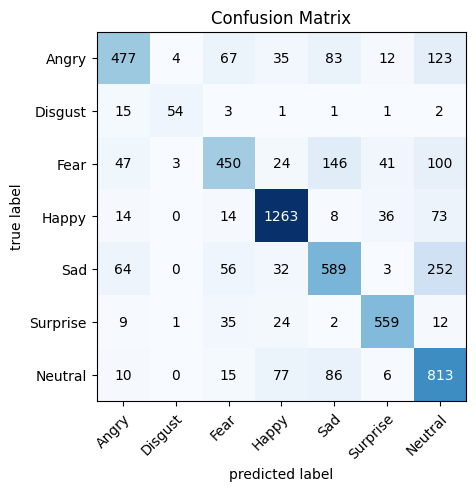

In [19]:
!pip install -U mlxtend > /dev/null 2>&1

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make predictions using the custom model
predictions_custom = custom_model.predict(x_test_split)
y_predict_custom = numpy.argmax(predictions_custom, axis=1)

# Create confusion matrix
conf_matrix_custom = confusion_matrix(y_test_split, y_predict_custom)

# Display confusion matrix
class_names_custom = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig_custom, ax_custom = plot_confusion_matrix(conf_mat=conf_matrix_custom, class_names=class_names_custom)
plt.title('Confusion Matrix')
plt.show()


In [21]:
from tensorflow.keras.preprocessing import image

def predict_facial_expression(image_path):
    """Predict facial expression for image"""
    # Open image
    grayscale_image = image.load_img(path=image_path,
                                     color_mode='grayscale',
                                     target_size=(48, 48))
    # Convert to array
    grayscale_array = image.img_to_array(grayscale_image)
    grayscale_array = numpy.expand_dims(grayscale_array, axis=0)

    # Show image
    grayscale_display = numpy.array(grayscale_array, 'float32')
    grayscale_display = grayscale_display.reshape([48, 48]);
    plt.imshow(grayscale_display, cmap='gray')
    plt.show()

    # Make predictions
    grayscale_array = grayscale_array / 255.0
    prediction = custom_model.predict(grayscale_array)

    # Draw the histogram
    plt.bar(y_positions, prediction[0], align='center', alpha=0.5)
    plt.xticks(y_positions, emotion_categories)
    plt.ylabel('Percentage')
    plt.title('Facial Expression Prediction')
    plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv('train.csv')

In [ ]:
# Load your CSV file (replace 'your_dataset.csv' with the actual file path)
import cv2
import numpy as np


def predict_facial_expression_from_csv(csv_row):
    """Predict facial expression for an image represented by a CSV row and visualize CAM"""
    # Extract pixel values from the CSV row
    pixels_str = csv_row[1]
    pixels_list = [int(i) for i in pixels_str.split(' ')]
    pixels_array = np.array(pixels_list, dtype='uint8').reshape((48, 48, 1))

    # Show image
    plt.imshow(pixels_array[:, :, 0], cmap='gray')
    plt.show()

    # Expand dimensions and normalize the pixel values
    pixels_array = np.expand_dims(pixels_array, axis=0) / 255.0

    # Make predictions
    predictions = custom_model.predict(pixels_array)
    predicted_class = np.argmax(predictions)

    # Get the CAM
    with tf.GradientTape() as tape:
        conv_output, predictions = cam_model(pixels_array)
        target_class_output = predictions[:, predicted_class]

    # Get the gradient of the target class with respect to the output feature map
    grads = tape.gradient(target_class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by "how important this channel is" with regard to the target class
    heatmap = tf.reduce_mean(conv_output * tf.expand_dims(pooled_grads, axis=0), axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Resize the heatmap to match the dimensions of the grayscale image
    heatmap_resized = cv2.resize(heatmap.numpy(), (pixels_array.shape[2], pixels_array.shape[1]))

    # Apply colormap to the resized heatmap
    heatmap_colored = plt.get_cmap('jet')(heatmap_resized)

    # Convert the superimposed image to the correct format
    grayscale_img = pixels_array[0][:, :, 0]  # Extract the grayscale image

    # Ensure both images have the same dimensions
    heatmap_colored_resized = cv2.resize(heatmap_colored[:, :, :3], (grayscale_img.shape[1], grayscale_img.shape[0]))

    # Combine the images
    superimposed_img = grayscale_img + 0.6 * heatmap_colored_resized

    # Display the superimposed image
    plt.imshow(superimposed_img, cmap='gray')
    plt.show()

    # Draw the histogram
    plt.bar(y_positions, predictions[0], align='center', alpha=0.5)
    plt.xticks(y_positions, emotion_categories)
    plt.ylabel('Percentage')
    plt.title('Facial Expression Prediction')
    plt.show()

# Example usage:
# Assuming df is your DataFrame containing the CSV data
for index, row in df.iterrows():
    predict_facial_expression_from_csv(row)
